In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.signal import get_window
from scipy.signal import find_peaks
from scipy.io import wavfile
from scipy.signal import savgol_filter
import IPython
import tensorflow as tf

In [2]:
model = tf.keras.models.load_model('model.h5')

In [7]:
fs, x = wavfile.read("samples/recording2.wav")
x = x / np.max(abs(x))

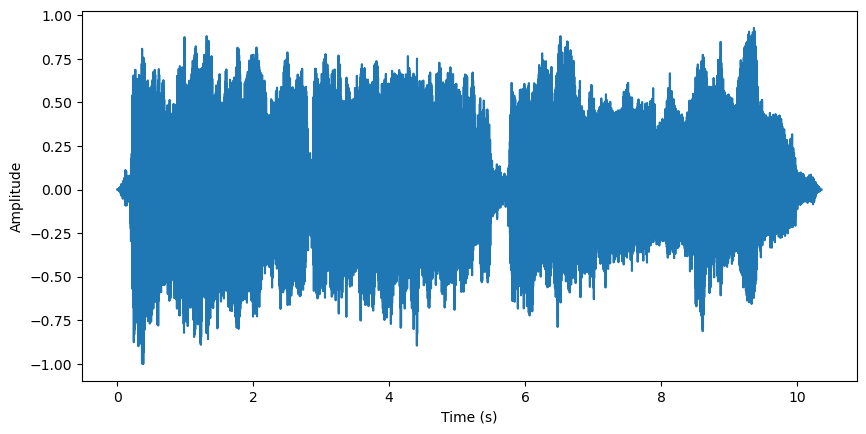

In [14]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
xTime = np.arange(len(x)) / fs
plt.plot(xTime, x)
IPython.display.Audio(x, rate=fs)

In [15]:
M = 8191
N = 8192
H = 2048

hM1 = int(math.floor((M + 1) / 2))
hM2 = int(math.floor(M / 2))
eps = np.finfo(float).eps

In [19]:
w  = get_window('blackman', M)
w = w / sum(w)

In [20]:
def computeSTFT(x):
    stft = []
    t_onset = []
    
    l = 0
    while l < len(x) - M:
        y = x[l: l + M]
        
        rmsframe = np.sqrt(np.dot(y, y) / M)    
        
        if rmsframe >= 0.1:
            y = y / np.max(abs(y))
            y = y * w

            fftBuffer = np.zeros(N)
            fftBuffer[: hM1] = y[hM2:] 
            fftBuffer[N - hM2:] = y[: hM2]

            X = fft(fftBuffer)
            absX = abs(X)
            absX[absX < np.finfo(float).eps] = np.finfo(float).eps
            mX = 10 * np.log10(absX)

            stft.append(mX)
        
        else:
            try:
                t_onset.append(len(stft))
            except:
                pass

        l += H
    
    return stft, t_onset

In [21]:
stft, t_onset = computeSTFT(x)

In [22]:
timeSteps = np.arange(len(stft))
frequencies = np.arange(N) * fs / N
cutoff = int(1000 * N / fs)

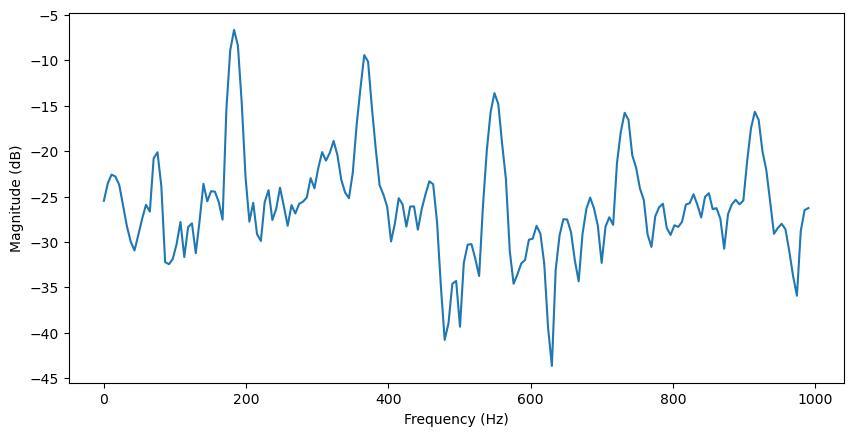

In [23]:
plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], stft[50][:cutoff])

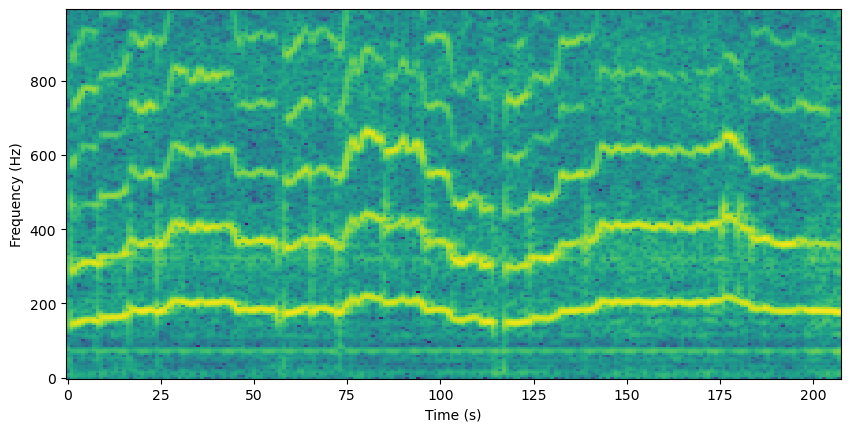

In [24]:
f = int(2500 * N / fs)
stft = np.array(stft)

plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(timeSteps, frequencies[:cutoff], stft.T[:cutoff])

In [28]:
peaks = []
k = 15

for frame_index in range(len(stft)):
    dft = stft[frame_index][: cutoff]
    dft_savgol = savgol_filter(dft, window_length=15, polyorder=5)

    bin = k
    while bin < len(dft) - 20: 
        if dft_savgol[bin] < -25: 
            bin += 1
            continue

        if dft_savgol[bin - 1] < dft_savgol[bin] and dft_savgol[bin] > dft_savgol[bin + 1]:# and model.predict(np.array([dft_savgol[bin: bin + 20][..., np.newaxis]]), verbose=False)[0][0] < 0.5:
            window = np.zeros(len(dft_savgol)) - 100
            window[bin: bin + 20] = dft[bin: bin + 20]

            peak = np.argmax(window) 

            if frame_index > 59 or frame_index in t_onset:
                k = 15
            else:
                k = max(peak - 10, 15)

            peaks.append(peak)

            break                
        else:
            bin += 1

In [27]:
peaks = []

for frame_index in range(len(stft)):
    dft = stft[frame_index][: cutoff]
    dft_savgol = savgol_filter(dft, window_length=15, polyorder=5)
    
    fpeaks, z = find_peaks(dft, height=-25, distance=12, prominence=5)
    ps = fpeaks[fpeaks > 15]

    for i in ps:
        if i > cutoff -10:
            break
        if model.predict(np.array([dft_savgol[i-10: i + 10][..., np.newaxis]]), verbose=False)[0][0] > 0.5:
            peaks.append(i)
            break

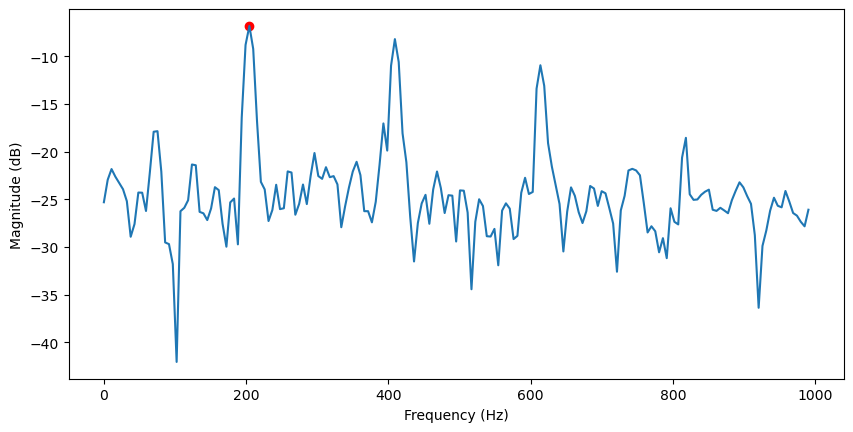

In [33]:
plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], stft[150][:cutoff])
plt.scatter(peaks[150] * fs / N, stft[150][int(peaks[150])], c='r')

In [30]:
fpeaks = find_peaks(stft[210][:cutoff], height=-25, distance=12, prominence=10)
p = fpeaks[0][fpeaks[0] > 15]

plt.figure().set_figwidth(10)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.plot(frequencies[:cutoff], stft[200][:cutoff])
plt.scatter(p * fs / N, stft[200][p], c='r')

IndexError: index 210 is out of bounds for axis 0 with size 208

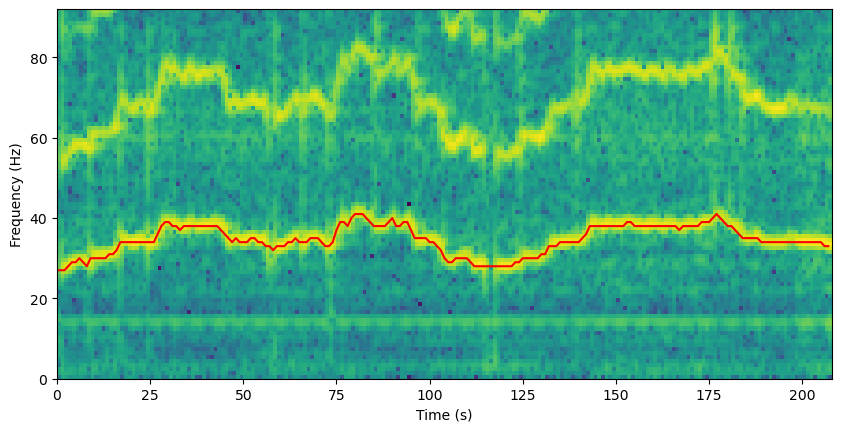

In [31]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(stft.T[:int(cutoff/2)])
plt.plot(np.array(peaks), c='r')

(1, 20, 1)


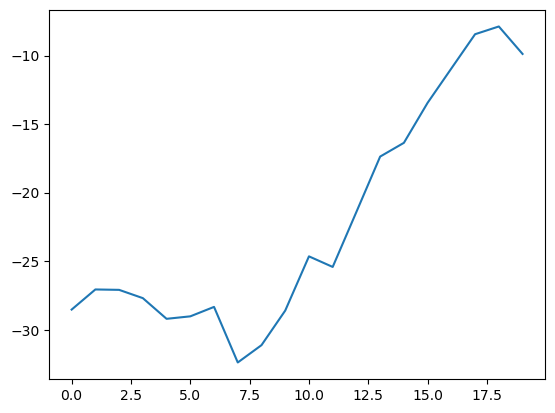

In [20]:
roi = np.array(stft[30][20:40])
plt.plot(roi)
roi = np.array([roi])
roi = roi[..., np.newaxis]
print(roi.shape)

In [50]:
model.predict([roi[..., np.newaxis]], verbose=False)[0][0] < 0.5

True

In [18]:
peaks = []

k = 15

for frame_index in range(len(stft)):
    dft = stft[frame_index]
    dft_savgol = savgol_filter(dft, window_length=15, polyorder=5)

    bin = k
    while bin < len(dft) - 20:
        roi = dft_savgol[bin: bin+20]
        roi = np.array([roi])
        roi = roi[..., np.newaxis]
        
        if np.round(model.predict(roi, verbose=False)):
            peaks.append(np.argmax(dft[bin: bin+20]) + bin)
            break
            
        bin += 15

KeyboardInterrupt: 

In [ ]:
plt.figure().set_figwidth(10)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.pcolormesh(stft.T[:int(cutoff/2)])
plt.plot(np.array(peaks), c='r')